In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

#Using Latex
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 9
})

rng = np.random.default_rng(0) #Setting the seed for reproductibility for the moment 

### Hamiltonian
$H = - \frac{1}{2}\sum_n^N h_n \sigma_z(n) - \frac{1}{2} \sum_n^{N-1} [ J_x^{(n)} \sigma_x(n) \sigma_x(n+1) + J_y^{(n)} \sigma_y(n) \sigma_y(n+1) +J_z^{(n)} \sigma_z(n) \sigma_z(n+1)]$


To this it is going to be added a Phase decoherence term of amplitude $\gamma_{n}$ to each of the spins

In [2]:
def single_particle_qubit_operators(num_spins):
    operators = {
        'X': [],
        'Y': [],
        'Z': []
    }
    for n in range(num_spins):
        Id = [qeye(2)]*num_spins
        for (name, op) in zip(['X', 'Y', 'Z'], [sigmax(), sigmay(), sigmaz()]):
            Id[n] = op
            operators[name].append(tensor(Id))
    return operators

def lindblad_operators(num_spins, h, J, gamma):
    ops = single_particle_qubit_operators(num_spins)
    # construct the Hamiltonian
    H = 0

    # energy splitting terms
    for n in range(num_spins):
        H += - 0.5 * h[n] * ops['Z'][n]

    # interaction terms
    for direction in ['X', 'Y', 'Z']:
        for n in range(num_spins-1):
            H += - 0.5 * J[direction][n] * ops[direction][n] * ops[direction][n+1]
        #H += - 0.5 * J[direction][num_spins-1] * ops[direction][0] * ops[direction][num_spins-1] #Periodic boundary conditions
    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(num_spins):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * ops['Z'][n])
    return H, c_op_list, ops #Hamiltonian, collapse operators, single_particle_operators

In [3]:
num_spins = 5          # number of spins
Hspace_dim = 2**num_spins
two_pi = np.full(num_spins, 2*np.pi)

interaction_coupling_constant = 0.1
h = 0.0*two_pi
J = {
    'X': 0.5*two_pi*interaction_coupling_constant,
    'Y': 0.5*two_pi*interaction_coupling_constant,
    'Z': two_pi*interaction_coupling_constant
}

# dephasing rate
gamma = 0.005 * np.ones(num_spins)

# intial state, first spin in state |↓>, the rest in state |↑>
psi_list = [basis(2,0)]*num_spins #Init everything at |↑>
psi_list[0] = basis(2,1) #Set first spin at |↓>

initial_state = tensor(psi_list)
integration_times = np.linspace(0, 100, 201)

H, collapse_operators, sp_operators = lindblad_operators(num_spins, h, J, gamma)
S_z = 0.5*sum([s_z.data.toarray() for s_z in sp_operators['Z']])
S_y = 0.5*sum([s_y.data.toarray() for s_y in sp_operators['Y']])
S_x = 0.5*sum([s_x.data.toarray() for s_x in sp_operators['X']])
S_sq = S_x@S_x + S_y@S_y + S_z@S_z

#Spin current
S_p = []
S_m = []
J_z = []
for n in range(num_spins):
    Id = [qeye(2)]*num_spins
    for op_list, op in zip([S_p, S_m], [sigmap(), sigmam()]):
        Id[n] = op
        op_list.append(tensor(Id))

for n in range(num_spins):
    if n < num_spins - 1:        
        J_z.append(1j*0.5*(S_p[n]*S_m[n + 1] - S_m[n]*S_p[n + 1])) #Outgoing current
        if n == 0:
            pass
        else:
            J_z[n] -= 1j*0.5*(S_p[n - 1]*S_m[n] - S_m[n - 1]*S_p[n]) #Incoming current
    else:
        J_z.append(-1j*0.5*(S_p[n - 1]*S_m[n] - S_m[n - 1]*S_p[n]))

options = Options()
options.store_states = True
result = mesolve(H, initial_state, integration_times, collapse_operators, sp_operators['Z'], options=options)


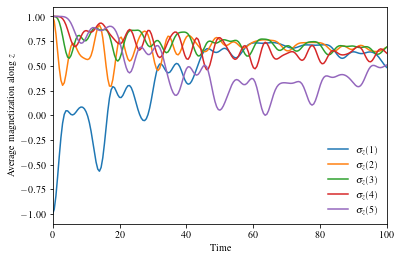

In [4]:
plt.plot(result.times, np.array(result.expect).T, label=[f"$\sigma_z({i + 1})$" for i in range(num_spins)])
plt.margins(x=0)
plt.ylabel('Average magnetization along $z$')
plt.xlabel('Time')
plt.legend(frameon=False)

### ML on resulted quantum states

In [5]:
#Kooplearn imports
import sys
sys.path.append("../../")
from kooplearn.kernels import Kernel
from kooplearn.estimators import ReducedRank, PrincipalComponent

class ComplexLinear(Kernel):
    def __call__(self, X, Y=None, backend = 'numpy'):
        if backend =='keops':
            raise NotImplementedError('Complex Kernel not yet implemented for Keops backend')
        else:
            if Y is None:
                return np.dot(X.conj(), X.T)
            else:
                return np.dot(X, Y.conj().T)

In [6]:
density_matrix_trajectory = np.array([rho.data.todense() for rho in result.states])
flattened_trajectory = np.reshape(density_matrix_trajectory, (density_matrix_trajectory.shape[0], -1))

In [7]:
init_states = flattened_trajectory[:-1]
evolved_states = flattened_trajectory[1:]

num_train = 100

kernel = ComplexLinear()

rank = 19
estimator = ReducedRank(kernel=kernel, rank=rank, tikhonov_reg=1e-6, override_array_checks=True)

In [8]:
estimator.fit(init_states[:num_train], evolved_states[:num_train])

ReducedRank(kernel=<__main__.ComplexLinear object at 0x7fe93e4397c0>,
            override_array_checks=True, rank=19, tikhonov_reg=1e-06)

### Forecast an observable

In [9]:
def average_spin_polarization(density_matrix, operators_dict, direction='Z', spin_particle = 0):
    S_op = operators_dict[direction][spin_particle].data.toarray().flatten()
    if density_matrix.ndim == 2: #Batched states (on the first dimension)
        avg = density_matrix@S_op
    elif density_matrix.ndim == 1: # Single state
        avg = np.dot(S_op,density_matrix)
    else:
        raise ValueError(f"Expected flattened density matrices, while density_matrix.ndim == {density_matrix.ndim}")
        
    assert np.abs(avg.imag).max() < 1e-8, "The computed expected value is not real"
    return avg.real

def average_spin_current(density_matrix, operators_list, spin_particle = 0):
    S_op = operators_list[spin_particle].data.toarray().flatten()
    if density_matrix.ndim == 2: #Batched states (on the first dimension)
        avg = density_matrix@S_op
    elif density_matrix.ndim == 1: # Single state
        avg = np.dot(S_op,density_matrix)
    else:
        raise ValueError(f"Expected flattened density matrices, while density_matrix.ndim == {density_matrix.ndim}")
        
    assert np.abs(avg.imag).max() < 1e-8, "The computed expected value is not real"
    return avg.real

def average_energy(density_matrix, H):
    h = H.data.toarray().flatten()
    if density_matrix.ndim == 2: #Batched states (on the first dimension)
        avg = density_matrix@h
    elif density_matrix.ndim == 1: # Single state
        avg = np.dot(h,density_matrix)
    else:
        raise ValueError(f"Expected flattened density matrices, while density_matrix.ndim == {density_matrix.ndim}")
        
    assert np.abs(avg.imag).max() < 1e-8, "The computed expected value is not real"
    return avg.real


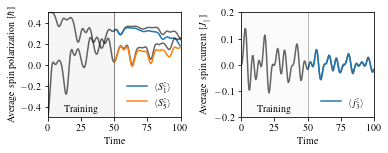

In [12]:
fig_width = 5.5 #Inches
fig_height =fig_width/2.5 #Inches
fig, axes = plt.subplots(ncols=2, figsize=(fig_width, fig_height), sharex='col')

#Selecting spin direction and index
direction = 'Z'
spin_particles = [0,4]

offset = 0 #Timesteps before the end of the training data to evaluate
starting_idx = num_train - offset
num_of_steps = 100 + offset #total number of steps to forecasts

dt = result.times[1] - result.times[0] #timestep
t0 = result.times[starting_idx] #initial time

forecasting_steps = np.arange(num_of_steps) 

rho_init = flattened_trajectory[starting_idx][None, :] #Initial state
forecasts = []

for spin_particle in spin_particles:
    #Spin polarization
    avg_op = lambda rho: average_spin_polarization(rho, sp_operators, direction=direction, spin_particle=spin_particle)

    forecast = np.squeeze(estimator.forecast(rho_init, forecasting_steps, avg_op))

    label = r"$\langle S_{}^{} \rangle$".format(spin_particle + 1, direction.lower())

    axes[0].plot(result.times, avg_op(flattened_trajectory)*0.5,'k-', alpha=0.6)
    axes[0].plot(t0 + forecasting_steps*dt, forecast*0.5, label = label)
    axes[0].fill_betweenx([-1,1], 0, result.times[num_train], alpha=0.02, color='k')
    axes[0].axvline(result.times[num_train], color='k', lw= 0.5, alpha=0.5)

for spin_particle in [2]:
    #Spin current
    avj_curr = lambda rho: average_spin_current(rho, J_z, spin_particle=spin_particle)

    forecast = np.squeeze(estimator.forecast(rho_init, forecasting_steps, avj_curr))

    label = r"$\langle j_{}^z \rangle$".format(spin_particle + 1)

    axes[1].plot(result.times, avj_curr(flattened_trajectory),'k-', alpha=0.6)
    axes[1].plot(t0 + forecasting_steps*dt, forecast, label = label)
    axes[1].fill_betweenx([-1,1], 0, result.times[num_train], alpha=0.02, color='k')
    axes[1].axvline(result.times[num_train], color='k', lw= 0.5, alpha=0.5)

axes[0].text(x = result.times[num_train]/2, y = -0.45, s='Training', horizontalalignment='center')
axes[0].margins(x=0)
axes[0].set_ylim(-0.5,0.5)
axes[0].set_xlabel('Time')

axes[0].set_ylabel('Average spin polarization [$\hbar$]')
axes[0].legend(frameon=False, loc='lower right')


axes[1].text(x = result.times[num_train]/2, y = -0.18, s='Training', horizontalalignment='center')
axes[1].margins(x=0)
axes[1].set_ylim(-0.2,0.2)
axes[1].set_xlabel('Time')

axes[1].set_ylabel('Average spin current [$J_{\parallel}$]')
axes[1].legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.savefig("figures/observables_forecast.pdf")

### Eigenvalues, modes and interpretability

In [69]:
evals, lefuns, refuns = estimator.eig(left=True, right=True)

modes = estimator.modes().T.reshape(Hspace_dim,Hspace_dim, -1) # [d, d, r] = [Hspace_dim, Hspace_dim, r]
levecs = lefuns(np.eye(Hspace_dim**2)).reshape(Hspace_dim,Hspace_dim, -1) # [d, d, r] = [Hspace_dim, Hspace_dim, r]
revecs = refuns(np.eye(Hspace_dim**2)).reshape(Hspace_dim,Hspace_dim, -1) # [d, d, r] = [Hspace_dim, Hspace_dim, r]

The evolution is given by $\rho(t) = \sum_{i = 1 }^{r} \lambda_{i}^{t/dt} \gamma^{Id}_{i} \langle \rho_{0}, \psi_{i} \rangle$, Defining $\Epsilon_{i}(\rho) := \gamma^{Id}_{i} \langle \rho, \psi_{i} \rangle$, the evolution is given by  $\rho(t) = \sum_{i = 1 }^{r} \lambda_{i}^{t/dt}\Epsilon_{i}(\rho_{0})$. What kind of maps are $\Epsilon_{i}$?

In [70]:
def cplxpairs(a, idxs = []):
    if a.ndim == 1:
        a = np.vstack([a, np.arange(a.shape[0])]) #first row: true values, second row: original indexes
    el = a[0,0]
    if np.abs(np.imag(el)) < 1e-10 : #Real number
        idx = int(np.real(a[1,0]))
        idxs.append((idx,))
        _a = np.delete(a, 0, 1)
    else: #Complex, search for complex conj.
        cconj_idx = np.argmin(np.abs(a[0] - np.conj(el)))
        if np.abs(a[0,cconj_idx] - np.conj(el)) >= 1e-10:
            raise ValueError() #Cannot find complex conjugate
        idx0 = int(np.real(a[1,0]))
        idx1 = int(np.real(a[1,cconj_idx]))
        idxs.append((idx0, idx1))
        _a = np.delete(a, (0, cconj_idx), 1)
    if _a.shape == (2,0):
        return idxs
    else:
        return cplxpairs(_a, idxs=idxs)

In [71]:
cplxpairs_idxs = cplxpairs(evals)

In [72]:
le_0 = lefuns(flattened_trajectory[0])
re_0 = refuns(flattened_trajectory[0])

def op_info(M):
    is_herm = np.allclose(M, M.conj().T)
    tr = np.trace(M)
    print(f"Hermitian: {is_herm}, Trace: {tr}")

for idx in cplxpairs_idxs:
    print(idx)
    if len(idx) == 1:
        i = idx[0]
        m = evals[i]*modes[...,i]*re_0[i]      
    else: #Complex conj pair
        i, j = idx
        m = evals[i]*modes[...,i]*re_0[i] + evals[j]*modes[...,j]*re_0[j]
    op_info(m)
    w, vecs = np.linalg.eigh(m)
    

(0,)
Hermitian: True, Trace: (1.1142423462341866-3.46848531127742e-12j)
(1, 2)
Hermitian: True, Trace: (-0.10468975207161742+3.13821776724843e-12j)
(3, 4)
Hermitian: True, Trace: (-0.00046162529548449127+2.4474237740601534e-14j)
(5, 6)
Hermitian: True, Trace: (-0.000743592574542238+2.9371213035485344e-13j)
(7, 8)
Hermitian: True, Trace: (-0.0010176742809653166-2.223004766377379e-14j)
(9, 10)
Hermitian: True, Trace: (0.0017964971976101793+7.935308226486582e-14j)
(11, 12)
Hermitian: True, Trace: (-0.0008968811742772129+7.413145618195838e-14j)
(13, 14)
Hermitian: True, Trace: (-0.002993701322552597-1.0152946192110157e-13j)
(15, 16)
Hermitian: True, Trace: (-0.001189089160368001+1.0415930271068241e-14j)
(17, 18)
Hermitian: True, Trace: (-0.0005266046804861813-2.4125666742147445e-14j)


In [87]:
#Timescales in units of timestep for given eigenvalues
def eigenvalues_timescale(eigenvalues, timestep):
    eps = 1e-12
    data = []
    for ev in eigenvalues:
        decay_length = np.around(((-np.log(np.abs(ev))**-1)*timestep)**-1, decimals = 3)
        if np.abs(np.imag(ev)) < eps:
            #Real eigenvalue
            period = None
            data.append((decay_length, period))
        else:
            #Imaginary eigenvalue
            period = np.around(2*np.pi*(np.angle(ev)**-1)*timestep, decimals=2)
            data.append((decay_length, period**-1))
    #Data format: (decay_length, period)
    return data

#Print timescales in units of timestep for given eigenvalues
def print_timescale(eigenvalues, timestep, units=''):
    data = eigenvalues_timescale(eigenvalues, timestep) 
    col_width = max(len(str(_x[0]) + " " + units) for _x in data) + 2  # padding
    for x in data:
        if x[1] == None:
            print(f"Decay:{x[0]} {units}")
        elif x[1] <= 0:
            pass
        else:
            a = str(x[0]) + " " + units
            print("Decay: " + a.ljust(col_width) + f"Period: {x[1]} {units}")

In [88]:
print_timescale(evals, dt)

Decay:0.003 
Decay: 0.014   Period: 0.0071911405148856605 
Decay: 0.026   Period: 0.05737234652897304 
Decay: 0.018   Period: 0.0706713780918728 
Decay: 0.018   Period: 0.078064012490242 
Decay: 0.019   Period: 0.12804097311139565 
Decay: 0.019   Period: 0.14144271570014144 
Decay: 0.018   Period: 0.1488095238095238 
Decay: 0.021   Period: 0.19880715705765406 
Decay: 0.02    Period: 0.2061855670103093 


In [89]:
evals

array([0.99853002+4.09105275e-14j, 0.99276994-2.24316881e-02j,
       0.99276994+2.24316881e-02j, 0.97132411-1.76973662e-01j,
       0.97132411+1.76973662e-01j, 0.96648658-2.18238274e-01j,
       0.96648658+2.18238274e-01j, 0.96146707+2.40612798e-01j,
       0.96146707-2.40612798e-01j, 0.91135615+3.87731334e-01j,
       0.91135615-3.87731334e-01j, 0.89443326-4.25606729e-01j,
       0.89443326+4.25606729e-01j, 0.88462459+4.46381678e-01j,
       0.88462459-4.46381678e-01j, 0.80284937-5.78620857e-01j,
       0.80284937+5.78620857e-01j, 0.78953201+5.97181680e-01j,
       0.78953201-5.97181680e-01j])

In [63]:
rho_ss = modes[...,0]*re_0[0] #Steady-state solution
ss_vals, ss_vecs = np.linalg.eigh(rho_ss)

conserved_op = revecs[...,0]
conserved_vals, conserved_vecs = np.linalg.eigh(conserved_op)

In [64]:
np.diag(density_matrix_trajectory[-1].real)

array([2.        , 0.44187578, 0.3924585 , 0.        , 0.37202308,
       0.        , 0.        , 0.        , 0.37412499, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.41951765, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Text(0.5, 1.0, 'Estimated')

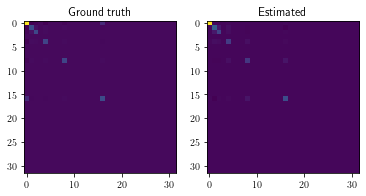

In [65]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(density_matrix_trajectory[-1].real)
ax[0].set_title("Ground truth")
ax[1].imshow(rho_ss.real)
ax[1].set_title("Estimated")


In [66]:
def pprint_state(vec):
    idxs_mask = (np.asarray(np.abs(vec) > 1e-15).nonzero())[0]
    s = ''
    for idx in idxs_mask:
        comp_basis = '{0:05b}'.format(idx).replace("0", "↑").replace('1', '↓')
        if np.abs(vec[idx].imag) >1e-2:
            coeff = vec[idx]
        else:
            coeff = vec[idx].real
        s += f'{coeff:.2f}|{comp_basis}〉 '
    print(s)

In [67]:
for i in range(10):
    i*=0.5
    print(f"{i}->{i*(i+1)}")

0.0->0.0
0.5->0.75
1.0->2.0
1.5->3.75
2.0->6.0
2.5->8.75
3.0->12.0
3.5->15.75
4.0->20.0
4.5->24.75


In [68]:
for idx in (np.asarray(np.abs(conserved_vals) > 1e-15).nonzero())[0]:
    vec = conserved_vecs[:,idx]
    avg_S_sq = np.vdot(vec, S_sq@vec).real
    avg_S_Z = np.vdot(vec, S_z@vec).real
    avg_S_Y = np.vdot(vec, S_y@vec).real
    avg_S_X = np.vdot(vec, S_x@vec).real
    print(f"Weight: {conserved_vals[idx]:.2f}, with 〈S²〉 = {avg_S_sq:.2f}, 〈S〉 = ({avg_S_X:.2f},{avg_S_Y:.2f},{avg_S_Z:.2f})")
    pprint_state(vec)

Weight: -0.90, with 〈S²〉 = 8.75, 〈S〉 = (0.01,0.00,2.50)
-1.00|↑↑↑↑↑〉 -0.00|↑↑↑↑↓〉 -0.00|↑↑↑↓↑〉 -0.00|↑↑↓↑↑〉 -0.00|↑↓↑↑↑〉 -0.00|↓↑↑↑↑〉 
Weight: -0.27, with 〈S²〉 = 4.51, 〈S〉 = (0.00,-0.00,1.50)
-0.00|↑↑↑↑↑〉 -0.17+0.68j|↑↑↑↑↓〉 -0.12+0.26j|↑↑↑↓↑〉 -0.10+0.03j|↑↑↓↑↑〉 -0.14-0.21j|↑↓↑↑↑〉 -0.30-0.51j|↓↑↑↑↑〉 
Weight: -0.23, with 〈S²〉 = 7.42, 〈S〉 = (-0.01,-0.00,1.50)
0.00|↑↑↑↑↑〉 -0.32-0.47j|↑↑↑↑↓〉 -0.23-0.17j|↑↑↑↓↑〉 -0.24-0.06j|↑↑↓↑↑〉 -0.32|↑↓↑↑↑〉 -0.66-0.04j|↓↑↑↑↑〉 
Weight: -0.15, with 〈S²〉 = 4.22, 〈S〉 = (-0.00,-0.00,1.50)
-0.00|↑↑↑↑↑〉 -0.13-0.33j|↑↑↑↑↓〉 0.12+0.58j|↑↑↑↓↑〉 0.50+0.24j|↑↑↓↑↑〉 0.31+0.12j|↑↓↑↑↑〉 -0.24-0.22j|↓↑↑↑↑〉 
Weight: -0.14, with 〈S²〉 = 3.82, 〈S〉 = (-0.00,-0.00,1.50)
0.00|↑↑↑↑↑〉 0.17-0.16j|↑↑↑↑↓〉 -0.23+0.59j|↑↑↑↓↑〉 -0.40-0.37j|↑↑↓↑↑〉 0.19-0.40j|↑↓↑↑↑〉 0.04+0.23j|↓↑↑↑↑〉 
Weight: -0.10, with 〈S²〉 = 3.79, 〈S〉 = (0.00,-0.00,1.50)
-0.00|↑↑↑↑↑〉 -0.04|↑↑↑↑↓〉 0.27+0.15j|↑↑↑↓↑〉 -0.37-0.43j|↑↑↓↑↑〉 0.10+0.72j|↑↓↑↑↑〉 0.03-0.24j|↓↑↑↑↑〉 


In [74]:
np.abs(conserved_op@S_z - S_z@conserved_op).max()

0.002112169604549845

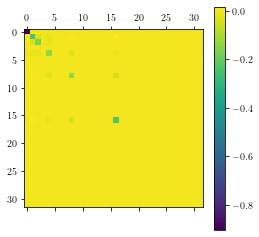

In [75]:
plt.matshow((conserved_op).real) #This is ~ the excited state population
plt.colorbar()

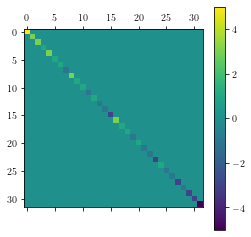

In [70]:
dir = 'Z'
tot_S = sum([s_z.data.toarray() for s_z in sp_operators[dir]])
tot_S_2 = sum([s_z.data.toarray()@s_z.data.toarray() for s_z in sp_operators[dir]])
plt.matshow(tot_S.real)
plt.colorbar()

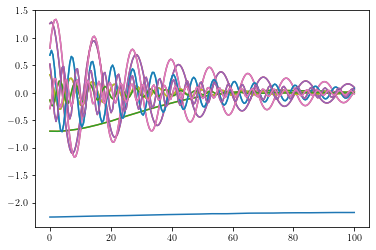

In [71]:
#Conserved quantity?
conserved = refuns(flattened_trajectory)
plt.plot(result.times, conserved.real)

### Questions:
1. Compute eigenfunctions of the Koopman operator and compare it to the eigenfunctions of the Liouvillian
2. Mode decomposition + dynamics discovery

In [16]:
modes = estimator.modes()
levecs = lf(np.eye(256))
revecs = rf(np.eye(256))
left_right_norms, _, _ = estimator._eig(_for_koopman_modes=True)

In [17]:
np.abs(estimator.V_.imag).max()

8.823733434090336e-15

In [18]:
Id = levecs.conj().T@revecs@left_right_norms
np.allclose(np.eye(7), Id)

True

In [19]:
nl = modes.T@revecs

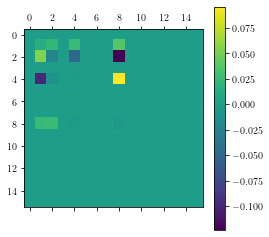

In [24]:
plt.matshow(np.imag(np.reshape(modes[:,6], (16,16))))
plt.colorbar()
